# Visualizing IV for NVIDIA using Yfinace data

In [1]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
# from py_black_scholes import black_scholes # Or your own IV calculator

# 1. Load NVDA Data
ticker_symbol = "NVDA"
nvda = yf.Ticker("NVDA")
# hist = nvda.history(period="6mo")
# hist
# nvda.info

In [2]:
nvda.calendar


{'Dividend Date': datetime.date(2025, 12, 26),
 'Ex-Dividend Date': datetime.date(2025, 12, 4),
 'Earnings Date': [datetime.date(2026, 2, 26)],
 'Earnings High': 1.59,
 'Earnings Low': 1.49,
 'Earnings Average': 1.52289,
 'Revenue High': 68755000000,
 'Revenue Low': 62306000000,
 'Revenue Average': 65550735640}

In [3]:
nvda.analyst_price_targets


{'current': 185.41,
 'high': 352.0,
 'low': 140.0,
 'mean': 253.62138,
 'median': 250.0}

In [4]:
# nvda.quarterly_income_stmt


In [5]:
# expirations = nvda.options
# expirations

In [6]:
from datetime import datetime
expirations = nvda.options
# all_options = pd.concat([nvda.option_chain(exp).calls for exp in expirations])

# all_options
# expirations

all_data = []

# Loop through expirations and add a 'daysToExpiration' column
for exp in expirations:
    opt = nvda.option_chain(exp).calls # Using calls for the surface
    # print(opt)

    opt['expiration'] = exp
    
    all_data.append(opt)


all_options = pd.concat(all_data)
# Calculate the difference from 'today' and convert to pandas date type
all_options['expiration'] = pd.to_datetime(all_options['expiration'])

today = pd.Timestamp('today').normalize()
all_options['daysToExpiration'] = (all_options['expiration'] - today).dt.days

all_options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration,daysToExpiration
0,NVDA260209C00120000,2026-02-03 20:02:27+00:00,120.0,57.70,63.10,68.40,0.000000,0.000000,1.0,1.0,3.042971,True,REGULAR,USD,2026-02-09,1
1,NVDA260209C00160000,2026-02-06 20:14:54+00:00,160.0,25.20,23.25,28.35,12.700001,101.600006,17.0,112.0,1.259769,True,REGULAR,USD,2026-02-09,1
2,NVDA260209C00165000,2026-02-06 18:12:02+00:00,165.0,19.55,19.65,22.35,11.349999,138.414630,98.0,199.0,1.153325,True,REGULAR,USD,2026-02-09,1
3,NVDA260209C00167500,2026-02-06 20:53:34+00:00,167.5,19.03,17.20,19.90,12.870001,208.928590,143.0,308.0,1.061528,True,REGULAR,USD,2026-02-09,1
4,NVDA260209C00170000,2026-02-06 20:46:37+00:00,170.0,16.34,15.55,16.55,11.809999,260.706400,2514.0,759.0,0.944336,True,REGULAR,USD,2026-02-09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,NVDA281215C00340000,2026-02-06 20:51:57+00:00,340.0,29.75,28.80,30.45,5.820000,24.320934,281.0,307.0,0.513799,False,REGULAR,USD,2028-12-15,1041
54,NVDA281215C00350000,2026-02-06 20:49:46+00:00,350.0,28.45,27.30,29.00,5.610001,24.562174,322.0,1827.0,0.511937,False,REGULAR,USD,2028-12-15,1041
55,NVDA281215C00360000,2026-02-06 20:21:45+00:00,360.0,26.41,26.30,27.75,4.450001,20.264120,90.0,881.0,0.512426,False,REGULAR,USD,2028-12-15,1041
56,NVDA281215C00370000,2026-02-06 20:51:57+00:00,370.0,26.00,25.10,26.80,5.090000,24.342420,6.0,832.0,0.512838,False,REGULAR,USD,2028-12-15,1041


In [7]:
# 2. Pivot for Visualization
# We use 'expiration' (the column we just created) instead of 'expirations'
surface_data = all_options.pivot_table(values='impliedVolatility', 
                                      index='strike', 
                                      columns='expiration')

# Remove NaN values that can break the surface plot
surface_data = surface_data.dropna(thresh=5) # Keep rows with at least 5 data points
surface_data = surface_data.interpolate(method='linear', axis=1).fillna(0)

# 3. 3D Plotly Visualization
fig = go.Figure(data=[go.Surface(
    z=surface_data.values,
    x=surface_data.columns, # Expiration dates
    y=surface_data.index,   # Strike prices
    colorscale='Viridis'
)])

fig.update_layout(
    title=f'{ticker_symbol} Volatility Surface',
    scene=dict(
        xaxis_title='Expiration Date',
        yaxis_title='Strike Price',
        zaxis_title='Implied Volatility'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show(renderer="iframe")

# Deriving AMD IV using Black-shole and visualizing IV with Yfinance data

In [8]:
import numpy as np
from scipy.stats import norm

# Black-Scholes Formula for Call Price
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Vega - derivative of price with respect to volatility
def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# Newton-Raphson for finding Implied Volatility
def find_iv(market_price, S, K, T, r, int_guess=0.3):
    sigma = int_guess
    for i in range(100):
        price = bs_call_price(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = market_price - price
        
        if abs(diff) < 1e-6:
            return sigma
        sigma = sigma + diff / vega # Newton step
    return sigma

In [9]:
# Input values for AMD
S_amd = 208.44
K_amd = 210.00
T_amd = 30 / 365  # 30 days
r_amd = 0.04
mkt_price = 12.50

amd_iv = find_iv(mkt_price, S_amd, K_amd, T_amd, r_amd)
print(f"The Implied Volatility for AMD is: {amd_iv:.2%}")

The Implied Volatility for AMD is: 54.18%


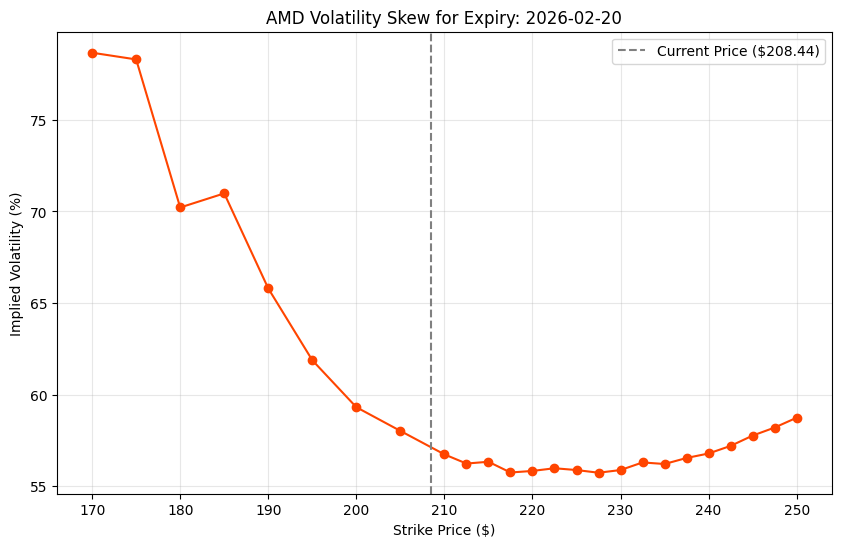

In [10]:
import matplotlib.pyplot as plt

# 1. Fetch AMD data from yfinance
amd = yf.Ticker("AMD")
expiry = amd.options[1]  # Selecting the second available expiry date
chain = amd.option_chain(expiry)
calls = chain.calls

# 2. Filter for liquidity (Open Interest > 100) and ATM strikes
# Focusing on the "Meat" of the Market (Strike Filtering)

current_price = amd.history(period="1d")['Close'].iloc[-1]
calls = calls[(calls['strike'] > current_price * 0.8) & (calls['strike'] < current_price * 1.2)]
calls = calls[calls['openInterest'] > 100]

# 3. Visualization
plt.figure(figsize=(10, 6))
plt.plot(calls['strike'], calls['impliedVolatility'] * 100, marker='o', linestyle='-', color='#ff4500')
plt.axvline(current_price, color='gray', linestyle='--', label=f'Current Price (${current_price:.2f})')

plt.title(f'AMD Volatility Skew for Expiry: {expiry}')
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Visualizing NIVDIA IV with GPR ML model 

In [11]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 1. Prepared Data for ML
#  X (Strike, DaysToExpiration) and y (Implied Volatility)
# 'all_options' is from our previous step
df_ml = all_options[['strike', 'daysToExpiration', 'impliedVolatility']].dropna()

X = df_ml[['strike', 'daysToExpiration']].values
y = df_ml['impliedVolatility'].values

# 2. Defined the GPR Model (The "Kernel" is the shape of the flex)
kernel = C(1.0, (1e-3, 1e3)) * RBF([10, 10], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 3. Fit the model to NVDA data
gp.fit(X, y)

# 4. Created a "Dense Grid" to predict values for a smooth surface
strike_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
time_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)
grid_strike, grid_time = np.meshgrid(strike_range, time_range)

# Predict IV for every point on the new grid
target_coords = np.vstack([grid_strike.ravel(), grid_time.ravel()]).T
predicted_iv, sigma = gp.predict(target_coords, return_std=True)
predicted_iv = predicted_iv.reshape(grid_strike.shape)



In [12]:
# 5. Plot the GPR ML Surface
fig = go.Figure(data=[go.Surface(z=predicted_iv, x=time_range, y=strike_range)])
fig.update_layout(title="NVDA Optimized ML Volatility Surface")
fig.show(renderer="iframe")